# Text Generation with Recurrent Neural Networks (RNNs)

In this assignment, you'll build upon your understanding of RNNs and Keras to develop a word-level text generation model.  Your goal is to train a model that learns the stylistic nuances of a chosen corpus and generates new, original text segments that echo the source material's essence.

**Datasets**

We've provided several intriguing text corpora to get you started:

*   Mark Twain
*   Charles Dickens
*   William Shakespeare

**Feel free to explore!**  If you have a particular passion for another author, genre, or a specific text, you're encouraged to use your own dataset of raw text.

In [1]:
# Check if we have a GPU available
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU available. If you're on Colab, go to Runtime > Change runtime and select a GPU hardware accelerator.")

No GPU available. If you're on Colab, go to Runtime > Change runtime and select a GPU hardware accelerator.


In [35]:
def download_file(url, file_path):
    import requests
    r = requests.get(url)
    with open(file_path, 'wb') as f:
        f.write(r.content)

def load_dataset(file_path, fraction=1.0):
    with open(file_path, 'r', encoding='utf-8') as f:
        raw_text = f.read()
    return raw_text[:int(fraction * len(raw_text))]

dataset = 'mark_twain.txt' # Other options are mark_twain.txt, charles_dickens.txt

download_file(f'https://raw.githubusercontent.com/UofT-DSI/deep_learning/refs/heads/main/02_activities/assignments/downloaded_books/' + dataset, dataset)

# Load chosen dataset. NOTE: If Colab is running out of memory, change the `fraction` parameter to a value between 0 and 1 to load less data.
text = load_dataset(dataset, fraction=0.1)

# 1. Data Preparation (Complete or Incomplete)

Before we can begin training an RNN model, we need to prepare the dataset. This involves cleaning the text, tokenizing words, and creating sequences the model can be trained on.

## 1.1 Data Exploration

Print the first 1000 characters of the dataset. Report the dataset's size and the number of unique characters it contains.

In [36]:
# Your code here
# Print the first 1000 characters of the dataset
print("First 1000 characters of the dataset:\n")
print(text[:1000])

# Report dataset size
dataset_size = len(text)
print(f"\nDataset Size (number of characters): {dataset_size}")

# Count unique characters
unique_characters = set(text)
num_unique_characters = len(unique_characters)

print(f"Number of Unique Characters: {num_unique_characters}")
print(f"Unique Characters: {sorted(unique_characters)}")

First 1000 characters of the dataset:


The Project Gutenberg EBook of The Prince and The Pauper, Complete by
Mark Twain (Samuel Clemens)

This eBook is for the use of anyone anywhere at no cost and with almost
no restrictions whatsoever. You may copy it, give it away or re-use
it under the terms of the Project Gutenberg License included with this
eBook or online at www.gutenberg.org

Title: The Prince and The Pauper, Complete

Author: Mark Twain (Samuel Clemens)

Release Date: August 20, 2006 [EBook #1837]
Last Updated: February 19, 2018

Language: English

Character set encoding: UTF-8

*** START OF THIS PROJECT GUTENBERG EBOOK PRINCE AND THE PAUPER ***

Produced by David Widger. The earliest PG edition was prepared by Les
Bowler




THE PRINCE AND THE PAUPER

by Mark Twain

The Great Seal

I will set down a tale as it was told to me by one who had it of his
father, which latter had it of HIS father, this last having in like
manner had it of HIS father--and so on, back and still back

## 1.2 Text Pre-Processing

To prepare the dataset for training, we need to clean the text and create a numerical representation the model can interpret. Perform the following pre-processing steps:

*   Convert the entire text to lowercase.
*   Use the `Tokenizer` class from the `keras.preprocessing.text` module to tokenize the text. You should fit the tokenizer on the text and then convert the text to a sequence of numbers. You can use the `texts_to_sequences` method to do this.

**Note**:
* You'll need to specify an appropriate size for the vocabulary. The number of words in the list of most common words can serve as a guide - does it seem like a reasonable vocabulary size?
* Some of the words will be excluded from the vocabulary, as they don't appear often enough. It's important to provide a value for `oov_token` when creating the Tokenizer instance, so that these words can be represented as "unknown".

In [37]:
from keras_preprocessing.text import Tokenizer

# Your code here
# Convert the text to lowercase
text = text.lower()

# Define constants
VOCAB_SIZE = 10000  # Define an appropriate vocabulary size
OOV_TOKEN = "<OOV>"  # Token for out-of-vocabulary words

# Initialize the Tokenizer
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)

# Fit the tokenizer on the text
tokenizer.fit_on_texts([text])

If everything worked, the following line should show you the first 10 words in the vocabulary:

In [38]:
try:
    print(list(tokenizer.word_index.items())[:10])
except AttributeError:
    print("Tokenizer has not been initialized. Possible issue: Complete the relevant section of the assignment to initialize it."
)


[('<OOV>', 1), ('the', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('in', 7), ('was', 8), ('he', 9), ('it', 10)]


## 1.3 Sequence Generation

Now that the text has been tokenized, we need to create sequences the model can be trained on. There are two parts to this:

*   Use the `texts_to_sequences` method from the tokenizer to convert the text to a list of sequences of numbers.
*   Generate the training sequences. Each training sequence should contain `SEQ_LENGTH` token IDs from the text. The target token for each sequence should be the word that follows the sequence in the text.

In [39]:
SEQ_LENGTH = 50 # Choose an appropriate sequence length

# Convert the text to a list of sequences of numbers
sequences = tokenizer.texts_to_sequences([text])[0]  # Flatten the list of lists into a single list of token IDs

# Generate the training sequences
X = []
y = []

# Your code here
for i in range(SEQ_LENGTH, len(sequences)):
    # Extract a sequence of SEQ_LENGTH tokens as the input
    X.append(sequences[i - SEQ_LENGTH:i])
    # The next token is the target
    y.append(sequences[i])

Assuming your sequences are stored in `X` and the corresponding targets in `y`, the following line should print the first training sequence and its target:

In [40]:
if len(X) > 0 and len(y) > 0:
    print(f'Sequence: {X[0]}\nTarget: {y[0]}')
    print(f'Translated back to words: {[tokenizer.index_word[i] for i in X[0]]} -> {tokenizer.index_word[y[0]]}')
else:
    print("Training sequences have not been generated. Possible issue: Complete the relevant section of the assignment to initialize it.")


Sequence: [2, 163, 151, 929, 4, 2, 84, 3, 2, 627, 1216, 24, 582, 776, 2261, 2747, 22, 929, 20, 16, 2, 327, 4, 1866, 1443, 23, 46, 826, 3, 14, 318, 46, 3108, 2513, 28, 154, 930, 10, 248, 10, 86, 36, 2514, 327, 10, 157, 2, 518, 4, 2]
Target: 163
Translated back to words: ['the', 'project', 'gutenberg', 'ebook', 'of', 'the', 'prince', 'and', 'the', 'pauper', 'complete', 'by', 'mark', 'twain', 'samuel', 'clemens', 'this', 'ebook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere', 'at', 'no', 'cost', 'and', 'with', 'almost', 'no', 'restrictions', 'whatsoever', 'you', 'may', 'copy', 'it', 'give', 'it', 'away', 'or', 're', 'use', 'it', 'under', 'the', 'terms', 'of', 'the'] -> project


And the following code will transform y into a one-hot encoded matrix, and split everything into training and validation sets:

In [41]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np

# Ensure that tokenizer has been initialized
if tokenizer is not None:
    # Convert X and y to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # One last thing: let's drop any examples where the target is the OOV token - we don't want our model to predict that (boring!)
    if OOV_TOKEN in tokenizer.word_index:
        mask = y != tokenizer.word_index[OOV_TOKEN]
        X = X[mask]
        y = y[mask]

    # One-hot encode the target token
    y = to_categorical(y, num_classes=VOCAB_SIZE)

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f'X_train shape: {X_train.shape}')
    print(f'y_train shape: {y_train.shape}')
else:
    print("Tokenizer has not been initialized. Please initialize it and load the vocabulary before continuing.")


X_train shape: (181554, 50)
y_train shape: (181554, 10000)


# 2. Model Development (Complete or Incomplete)

With the dataset prepared, it's time to develop the RNN model. You'll need to define the architecture of the model, compile it, and prepare it for training.

## 2.1 Model Architecture

Define the architecture of your RNN model. You can design it however you like, but there are a few features that it's important to include:

*   An embedding layer that learns a dense representation of the input tokens. You'll need to specify the input dimension (the size of the vocabulary) and the output dimension (the size of the dense representation). Remember, you can look at the documentation [here](https://keras.io/api/layers/core_layers/embedding/).
*   At least one recurrent layer. We have learned how to use LSTM layers in class, but you can use other types of recurrent layers if you prefer. You can find the documentation [here](https://keras.io/api/layers/recurrent_layers/lstm/).
*   A dense layer with a softmax activation function. This layer will output a probability distribution over the vocabulary, so that the model can make predictions about the next token.

In [42]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

# Define constants
VOCAB_SIZE = 10000  # Size of the vocabulary
EMBEDDING_DIM = 128  # Dimension of the dense embedding
RNN_UNITS = 256  # Number of units in the recurrent layer

# Build the RNN model
model = Sequential([
    # Embedding layer: input_dim is the size of the vocabulary, output_dim is the embedding size
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=SEQ_LENGTH),

    # LSTM layer: A recurrent layer to process sequential data
    LSTM(RNN_UNITS, return_sequences=False),

    # Dense output layer with softmax activation
    Dense(VOCAB_SIZE, activation='softmax')
])

# Check if the model has layers before trying to print the summary
if len(model.layers) > 0:
    model.summary()
else:
    print("No layers have been added to the model. Please complete the assignment by adding the required layers.")

/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 2.2 Model Compilation

Compile the model with an appropriate loss function and optimizer. You might also want to track additional metrics, such as accuracy.

Give a short explanation of your choice of loss function and optimizer:

_your explanation here_

	# Choice of Loss Function and Optimizer:
    •	Categorical Crossentropy: As it is best suited for multi-class classification tasks like word prediction.
	•	Adam Optimizer: Handles learning rate adjustments efficiently, making it a robust choice for RNNs.

In [43]:
# Your code here
# Compile the model
model.compile(
    optimizer='adam',  # Adam optimizer for efficient training
    loss='categorical_crossentropy',  # Loss function for multi-class classification
    metrics=['accuracy']  # Track accuracy during training
)

print("Model compiled successfully.")

Model compiled successfully.


## 2.3 Model Training

Train the model on the training data you've prepared.

* Train your model for 5 epochs with a batch size of 128. Use the validation data for validation.
* Store the training history in a variable called `history`.

In [31]:
# Your code here
# Train the model
history = model.fit(
    X_train, y_train,  # Training data
    validation_data=(X_val, y_val),  # Validation data
    epochs=5,  # Number of epochs
    batch_size=128,  # Batch size
    verbose=1  # Show progress during training
)

Epoch 1/5
1419/1419 ━━━━━━━━━━━━━━━━━━━━ 200s 141ms/step - accuracy: 0.0670 - loss: 7.0036 - val_accuracy: 0.0948 - val_loss: 6.3775
Epoch 2/5
1419/1419 ━━━━━━━━━━━━━━━━━━━━ 200s 141ms/step - accuracy: 0.1067 - loss: 6.1420 - val_accuracy: 0.1191 - val_loss: 5.9626
Epoch 3/5
1419/1419 ━━━━━━━━━━━━━━━━━━━━ 199s 140ms/step - accuracy: 0.1324 - loss: 5.6025 - val_accuracy: 0.1348 - val_loss: 5.6324
Epoch 4/5
1419/1419 ━━━━━━━━━━━━━━━━━━━━ 202s 142ms/step - accuracy: 0.1539 - loss: 5.0821 - val_accuracy: 0.1500 - val_loss: 5.3926
Epoch 5/5
1419/1419 ━━━━━━━━━━━━━━━━━━━━ 197s 139ms/step - accuracy: 0.1840 - loss: 4.6075 - val_accuracy: 0.1606 - val_loss: 5.2234


Plot the training history to visualize the model's learning progress. Your plot should include the training and validation loss.

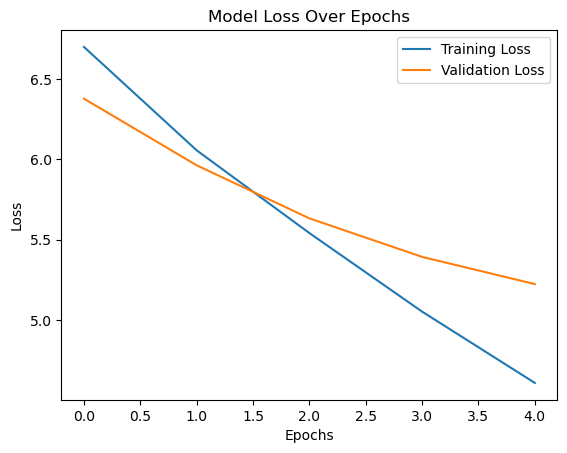

In [44]:
import matplotlib.pyplot as plt

# Your code here
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 3. Text Generation (Complete or Incomplete)

Write a method called `generate_text` that uses the trained model to generate new text. The method should take the following parameters:

*   `model`: The trained RNN model.
*   `tokenizer`: The tokenizer used to pre-process the text data.
*   `seed_text`: The seed text the model will use to generate new text.
*   `max_sequence_len`: The maximum length of the sequence used to generate new text.

The method should return the generated text.

An overview of the text generation process you should follow:

1. Tokenize the seed text using the tokenizer we built before.
2. Pad the sequences to the same length as the training sequences - you can use the `pad_sequences` method from the `keras.preprocessing.sequence` module, which is documented [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences).
3. Use the model to predict the next token in the sequence. Remember that the model will output a probability distribution over the vocabulary, so you'll need to use `np.argmax` to find the token with the highest probability.
4. Add the predicted token to the sequence and remove the first token.
5. Repeat steps 3-4 until you have generated the desired number of tokens.
6. Convert the generated token IDs back to words and return the combined result as a single string.

This is a challenging task, so don't hesitate to ask for help if you need it. It's okay if the generated text doesn't make much sense yet - we'll work on improving the model next.
As a bonus, you can make your method generate "gpt-style" by having it print out each word as it's generated, so you can see the text being generated in real time.

In [50]:
from keras.preprocessing.sequence import pad_sequences

def get_predicted_word(model, sequence):
    """
    Get the predicted word from the model.
    This helper function uses a concept we haven't covered in class yet: temperature.
    In essence, a little bit of randomness in what word we predict can make the text more interesting.
    """

    # Use the model to predict the next token in the sequence
    yhat = model.predict(sequence, verbose=0)

    # Get the index of the predicted word, according to the probabilities
    yhat = np.random.choice(range(VOCAB_SIZE), p=yhat.ravel())

    return yhat

def generate_text(model, tokenizer, seed_text, max_sequence_len, num_words=50):
    """
    Generate new text using the trained model.
    You can use the `get_predicted_word` helper function to help you with this.
    """
    
    # Step 1: Tokenize the seed text
    tokenized_seed = tokenizer.texts_to_sequences([seed_text])[0]
    
    # Step 2: Pad the tokenized sequence to match the training sequence length
    padded_sequence = pad_sequences([tokenized_seed], maxlen=max_sequence_len, padding='pre')

    # List to hold the generated words
    generated_words = []

    # Step 3: Generate the next 'num_words' tokens
    for _ in range(num_words):
        # Step 4: Get the predicted word
        predicted_token = get_predicted_word(model, padded_sequence)

        # Step 5: Convert the predicted token ID to a word
        predicted_word = tokenizer.index_word.get(predicted_token, '<OOV>')

        # Print the generated word
        print(predicted_word, end=' ', flush=True)  # Print without a newline, flush to display immediately

        # Append the word to the generated words list
        generated_words.append(predicted_word)

        # Step 6: Update the sequence for the next prediction
        tokenized_seed.append(predicted_token)
        tokenized_seed = tokenized_seed[1:]

        # Re-pad the sequence to the required length
        padded_sequence = pad_sequences([tokenized_seed], maxlen=max_sequence_len, padding='pre')

    # Step 7: Return the generated text as a string
    generated_text = ' '.join(generated_words)
    return None


In [52]:
# Test the text generation function
generate_text(model, tokenizer, 'The Prince and The Pauper', SEQ_LENGTH)

aground lengthy leniency shows coigns threadbare frowsy over” many “set less outcome interpret exemplary but people’s  lift purfled fiends raw “dig detail fondly troubles inventing tiptoe arms” faculties yes enjoying trees curls tireless celerity dauntless entertaining semi into entrances tore state’s flowers blithely taffeta buskins dowgate warn't welcomed malignant occupying 

It's likely that the text generated by your model doesn't make much sense yet. This is because the model hasn't been trained for very long, and the training dataset is relatively small. 

# 4. Model Refinement (Complete or Incomplete)

In this last section, you'll work on improving your model. There are many ways to do this, but here are a few ideas to get you started:

* Use pre-trained embeddings: the code below will help you to load pre-trained embeddings through Keras. 
* Experiment with different model architectures, including the number of layers, the number of units in each layer, and the use of dropout layers.
* Train your model for longer. You can also experiment with different batch sizes.

Implement and test out at least one of these ideas. If you have other ideas for improving the model, feel free to try them out as well.

In [56]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip glove.6B.zip

--2024-11-30 16:08:35--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M   835KB/s    in 16m 32s 

2024-11-30 16:25:07 (849 KB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [57]:
# Load the pre-trained embeddings
embeddings_index = {}
try:
    with open('glove.6B.100d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f'Found {len(embeddings_index)} word vectors.')
except FileNotFoundError:
    print("'glove.6B.100d.txt' File not found. Please make sure you have ran the previous cell.")

Found 400000 word vectors.


In [58]:
# Check if VOCAB_SIZE is set
if VOCAB_SIZE is None:
    print("You need to complete the previous parts of your assignment in order for this to work.")
else:
    # Create an embedding matrix
    embedding_matrix = np.zeros((VOCAB_SIZE, 100))
    for word, i in tokenizer.word_index.items():
        if i < VOCAB_SIZE:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

In [59]:
# Check if VOCAB_SIZE is set
if VOCAB_SIZE is None:
    print("You need to complete the previous parts of your assignment in order for this to work.")
else:
    embedding_layer = Embedding(
        VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=SEQ_LENGTH, trainable=False
    )

/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [63]:
# Define a new model and train it
from keras.layers import Dropout

model = Sequential()

# Use the pre-trained embedding layer
model.add(embedding_layer)

# First LSTM layer
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(128))
model.add(Dropout(0.2))

# Dense output layer with softmax activation
model.add(Dense(VOCAB_SIZE, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary to check the architecture
model.summary()



Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 50, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

In [64]:
# Train the model for more epochs
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_val, y_val))

Epoch 1/10
1419/1419 ━━━━━━━━━━━━━━━━━━━━ 206s 145ms/step - accuracy: 0.0605 - loss: 7.0266 - val_accuracy: 0.0763 - val_loss: 6.5854
Epoch 2/10
1419/1419 ━━━━━━━━━━━━━━━━━━━━ 202s 143ms/step - accuracy: 0.0822 - loss: 6.4619 - val_accuracy: 0.0922 - val_loss: 6.3097
Epoch 3/10
1419/1419 ━━━━━━━━━━━━━━━━━━━━ 206s 145ms/step - accuracy: 0.0953 - loss: 6.1569 - val_accuracy: 0.1069 - val_loss: 6.0670
Epoch 4/10
1419/1419 ━━━━━━━━━━━━━━━━━━━━ 207s 146ms/step - accuracy: 0.1043 - loss: 5.8871 - val_accuracy: 0.1143 - val_loss: 5.8917
Epoch 5/10
1419/1419 ━━━━━━━━━━━━━━━━━━━━ 926s 653ms/step - accuracy: 0.1125 - loss: 5.6588 - val_accuracy: 0.1192 - val_loss: 5.7676
Epoch 6/10
1419/1419 ━━━━━━━━━━━━━━━━━━━━ 205s 145ms/step - accuracy: 0.1159 - loss: 5.4722 - val_accuracy: 0.1237 - val_loss: 5.6741
Epoch 7/10
1419/1419 ━━━━━━━━━━━━━━━━━━━━ 208s 147ms/step - accuracy: 0.1209 - loss: 5.3034 - val_accuracy: 0.1248 - val_loss: 5.6049
Epoch 8/10
1419/1419 ━━━━━━━━━━━━━━━━━━━━ 201s 142ms/step - ac

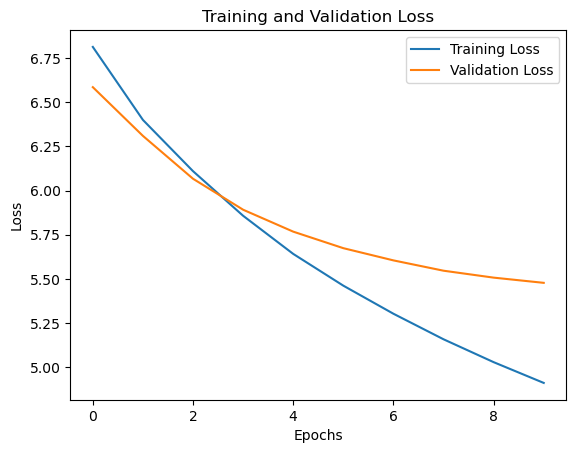

In [65]:
# Plot the training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Criteria

|Criteria|Complete|Incomplete|
|----|----|----|
|Task 1|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 2|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 3|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 4|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|

## Submission Information

🚨**Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)**🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.